### Toy problem simulating non-stationary timeseries with "regime-shift"

Compare prediction performance of base Echo State Networks (ESNs) with CNN/LSTM hybrid network.

**Outline**

Create timeseries with increasing complexity / difficulty:

* sin + noise, one amplitude $a_1$, one frequency $f_1$
* **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_1$, one frequency $f_2$
* **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_2$, one frequency $f_1$
* **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_2$, one frequency $f_2$

Look at accuracy (correctly predicted up/down movements) and mean-absolute-error (mae) in total and seperately for both regimes.

**Possible extensions**

* Neglect trend in first step, assume de-trending series is not a big deal.
* Could try to increase noise or different noise-regimes.



### Technical setup and data preparation

In [1]:
import time
import math
import numpy as np
from scipy.special import expit  # vectorized logistig function
import matplotlib.pyplot as plt

# Work with my own library of useful ESN functions
from ESN_functions_v01 import *

In [2]:
### Create some data

# Specify number of steps per regime.
n_ = 1000

# Specify input for sin function with linspace(start, stop, numsteps)
t = np.linspace(0, 20*np.pi, n_) 

In [18]:
# Create input_1: 

# Set the one amplitude a1, and one base frequency f1
a1 = 1
f1 = 1

# Set noise standard deviation parameter n1
n1 = 1

# Add noise with np.random.normal(mean, std, numsteps).
input_1 = a1 * np.sin(f1 * t) + np.random.normal(0, n1, n_)

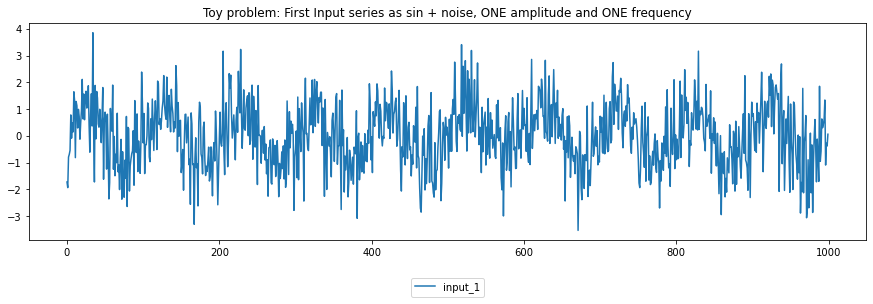

In [19]:
# Plot 1st input series
plt.figure(figsize=(15, 4))
plt.plot(range(len(input_1)), input_1, label='input_1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title('Toy problem: First Input series as sin + noise, ONE amplitude and ONE frequency')
plt.show()

In [24]:
# create rel. change inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_1, 
                                                                                    input_length = 10, 
                                                                                    target_length = 1, 
                                                                                    time_lag=0,
                                                                                    train_val_split=0.8, 
                                                                                    abs_to_rel_YN=False,
                                                                                    binary_YN=False, 
                                                                                    scaled_YN=False,
                                                                                    verbose=True)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=100, 
                              sparsity=0.2, 
                              spectral_rad=1.2, 
                              w_in_lim=1.0, 
                              activation='sigmoid', 
                              verbose=True)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation='sigmoid',
                                              scaled_YN=False, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=True)

raw data shape:  (1000,)
train_input shape:  (792, 10, 1)
val_input shape:  (198, 10, 1)
train_target shape:  (792,)
val_target shape:  (198,)
train_min:  0
train_max:  0
train_input shape:  (792, 10)
train_target shape:  (1, 792)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.48
W_res sparsity:  0.203
val_input shape:  (198, 10)
val_target shape:  (198,)
val_pred shape:  (198,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  0.535
ESN pred. accuracy:  0.631
ESN mean abs. error:  0.9574


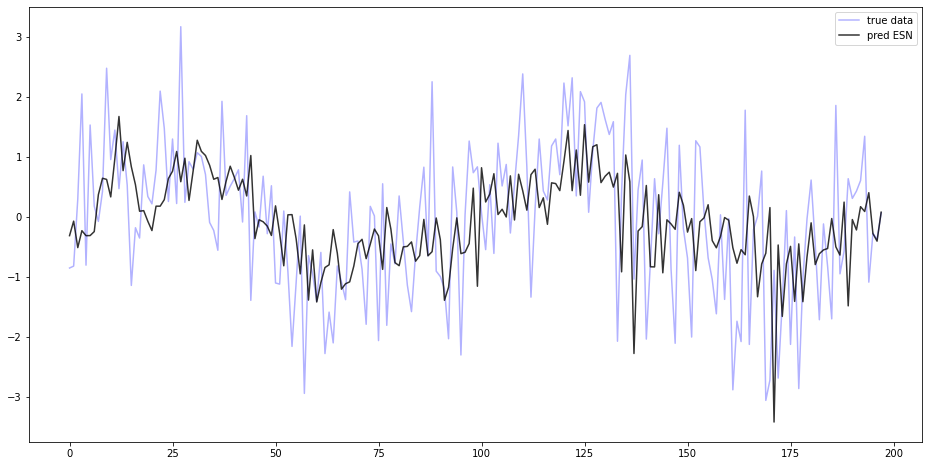

In [25]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.legend()
plt.show()

In [26]:
# Read dataset amazon.txt, absolute values:
data_abs = open("../data/amazon_2010_2021_close.txt").read().split()
data_abs = np.array(data_abs).astype('float64')

In [27]:
# create rel. change inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(data_abs, 
                                                                                    input_length = 10, 
                                                                                    target_length = 1, 
                                                                                    time_lag=0,
                                                                                    train_val_split=0.8, 
                                                                                    abs_to_rel_YN=False,
                                                                                    binary_YN=False, 
                                                                                    scaled_YN=False,
                                                                                    verbose=True)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=100, 
                              sparsity=0.2, 
                              spectral_rad=1.2, 
                              w_in_lim=1.0, 
                              activation='sigmoid', 
                              verbose=True)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation='sigmoid',
                                              scaled_YN=False, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=True)

raw data shape:  (3020,)
train_input shape:  (2408, 10, 1)
val_input shape:  (602, 10, 1)
train_target shape:  (2408,)
val_target shape:  (602,)
train_min:  0
train_max:  0
train_input shape:  (2408, 10)
train_target shape:  (1, 2408)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
W_res max:  0.507
W_res sparsity:  0.2
val_input shape:  (602, 10)
val_target shape:  (602,)
val_pred shape:  (602,)
W_in shape:  (100, 1)
W_out shape:  (1, 100)
W_res shape:  (100, 100)
up movements percentage in val_target:  1.0
ESN pred. accuracy:  1.0
ESN mean abs. error:  1452.6986


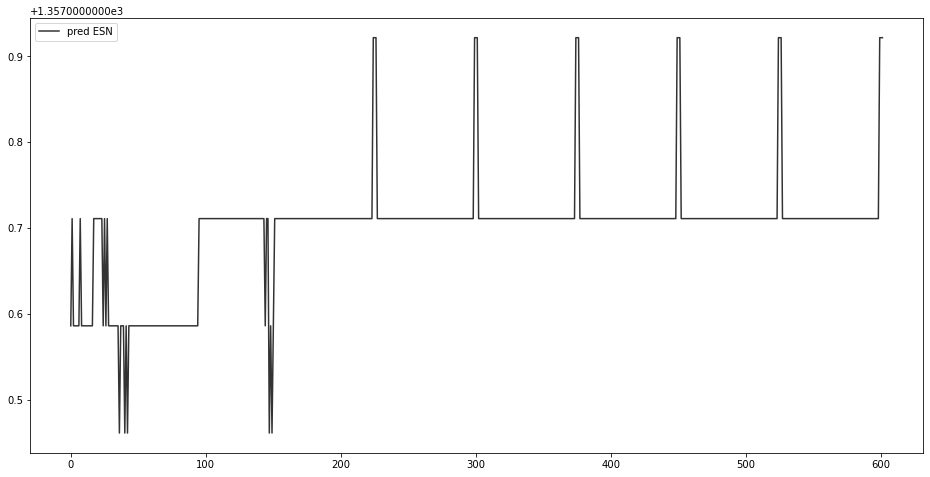

In [29]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
#plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.legend()
plt.show()